# task1 PyTorch的基本概念

## 安装

参考
[WIn10+Anaconda 环境下安装 PyTorch 避坑指南](https://blog.csdn.net/red_stone1/article/details/86669362)

```
# Python 3.6
pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-win_amd64.whl
pip3 install torchvision
```

虽然本来安装了anaconda，但是最后还是用pip安装成功的，不过没有出现参考文章中import torchvision 报错的情况，直接就成功了

## 简单操作

In [17]:
import torch
import torchvision
from __future__ import print_function

创建一个没有初始化的5*3矩阵：

In [4]:
x = torch.empty(5, 3)
print(x)

tensor([[0.0000e+00, 0.0000e+00, 1.9394e-42],
        [0.0000e+00, 7.0065e-45, 0.0000e+00],
        [1.2243e-32, 7.6231e-43, 0.0000e+00],
        [0.0000e+00, 1.8368e-40, 0.0000e+00],
        [1.2271e-32, 7.6231e-43, 0.0000e+00]])


实现一个只有输入层、单隐藏层、输出层的一个神经网络。假设样本数为64个，输入维度为1000，隐藏层为100，输出层为10。

参考[简单神经网络在Numpy和Pytorch上的实现](https://blog.csdn.net/herosunly/article/details/88949873)

In [5]:
num_samples = 64 # N
dim_in, dim_hid, dim_out = 1000, 100, 10  # IN H OUT
x = torch.randn(num_samples, dim_in)  #  N * IN
y = torch.randn(num_samples, dim_out) #  N * OUT

w1 = torch.randn(dim_in, dim_hid)     # IN * H
w2 = torch.randn(dim_hid, dim_out)    #  H * OUT

eta = 1e-6
for i in range(100):
    #Forward pass
    h = x @ w1                              # N * H
    h_relu = h.clamp(min = 0)               # N * H
    y_pred = h_relu @ w2                    # N * OUT

    #Loss
    loss = (y_pred - y).pow(2).sum().item()
    print('times is {}, loss is {}'.format(i, loss))

    #Backward pass
    grad_y_pred = 2.0 * (y_pred - y)        # N * OUT
    grad_w2 = (h_relu.t()) @ (grad_y_pred) #H * OUT = (H * N) * (N * OUT)，其中(H * N) = (N * H).T

    grad_h_relu = grad_y_pred @ ((w2.t()))# N * H = (N * OUT) * (OUT * H)，其中(OUT * H) = (H * OUT).T
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0

    grad_w1 = (x.t()) @ (grad_h)  # IN * H = （IN * N） * (N * H)

    w1 = w1 - eta * grad_w1
    w2 = w2 - eta * grad_w2

times is 0, loss is 35796332.0
times is 1, loss is 33882276.0
times is 2, loss is 37255088.0
times is 3, loss is 38358232.0
times is 4, loss is 32414816.0
times is 5, loss is 20876616.0
times is 6, loss is 10788002.0
times is 7, loss is 5110846.0
times is 8, loss is 2648155.75
times is 9, loss is 1628313.0
times is 10, loss is 1166648.125
times is 11, loss is 916277.375
times is 12, loss is 753955.5625
times is 13, loss is 634853.8125
times is 14, loss is 541507.3125
times is 15, loss is 465717.28125
times is 16, loss is 402981.40625
times is 17, loss is 350550.125
times is 18, loss is 306293.8125
times is 19, loss is 268657.5625
times is 20, loss is 236419.875
times is 21, loss is 208721.890625
times is 22, loss is 184855.78125
times is 23, loss is 164170.921875
times is 24, loss is 146209.078125
times is 25, loss is 130524.1015625
times is 26, loss is 116799.9140625
times is 27, loss is 104769.3125
times is 28, loss is 94199.78125
times is 29, loss is 84857.015625
times is 30, loss i

# task2 设立计算图并自动计算

## 一、线性回归 y = w1*x1 + w2*x2

In [8]:
w1 = 4
w2 = -3

$\operatorname{loss}=\frac{1}{2n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}$

$\frac{dloss}{d w_{1}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{1_{i}}$

$\frac{dloss}{d w_{2}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{2_{i}}$

### 1、numpy方式

In [209]:
import numpy as np
import matplotlib.pyplot as plt

In [210]:
x_data = np.array([[1,2,3],
                   [3,1,2]])
y_data = w1 * x_data[0] + w2 * x_data[1]

In [211]:
y_data

array([-5,  5,  6])

In [212]:
epochs = 10
rate = 0.1
w1_ = 0
w2_ = 0
cost = []

In [213]:
for epoch in range(epochs):
    y_ = w1_ * x_data[0] + w2_ * x_data[1]
    #print(y_)
    #计算损失
    loss = np.average((y_ - y_data)**2)/2.0
    cost.append(loss)
    
    #计算梯度
    dw1 = (y_ - y_data) @ x_data[0].T/(x_data.shape[1])
    dw2 = (y_ - y_data) @ x_data[1].T/(x_data.shape[1])
    #print(dw1,dw2)
    #参数更新
    w1_ = w1_ - rate * dw1
    w2_ = w2_ - rate * dw2
    print(w1_,w2_)

0.7666666666666667 0.06666666666666667
1.1511111111111112 -0.17888888888888888
1.4461851851851852 -0.4508148148148148
1.7032641975308642 -0.7040358024691358
1.9332206995884773 -0.9333493004115226
2.1399457832647464 -1.1399672167352537
2.3259590638774577 -1.3259626361225423
2.4933644673129094 -1.4933650626870905
2.6440282388854848 -1.6440283381145149
2.7796254513809138 -1.7796254679190857


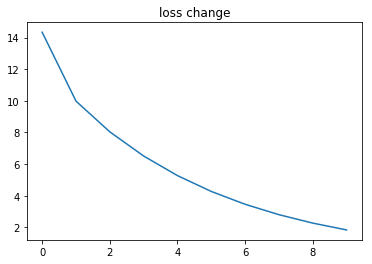

In [214]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

### 2、torch 方式

In [18]:
from torch.autograd import Variable

In [201]:
torch.manual_seed(2)

In [215]:
x_data = Variable(torch.Tensor([[1.0,3.0],[2.0,1.0],[3.0,2.0]]))
y_data = Variable(torch.Tensor([[-5.0],[5.0],[6.0]]))

In [216]:
x_data

tensor([[1., 3.],
        [2., 1.],
        [3., 2.]])

In [217]:
y_data

tensor([[-5.],
        [ 5.],
        [ 6.]])

In [227]:
epochs = 10
rate = 0.1
w = Variable(torch.FloatTensor([[0],[0]]))
w.requires_grad_(True)
cost = []

In [228]:
for epoch in range(epochs):
    y_ = x_data.mm(w)
    #print(y_)
    loss = ((y_ - y_data)**2).mean()/2.0
    cost.append(float(loss.data))
    loss.backward()
    w.data = w.data - rate * w.grad.data
    
    #print(w.grad.data)
    #这一步很关键，必须清零，因为 .grad这个属性值是累加的
    w.grad.data.zero_()
    print(w.data)

tensor([[0.7667],
        [0.0667]])
tensor([[ 1.1511],
        [-0.1789]])
tensor([[ 1.4462],
        [-0.4508]])
tensor([[ 1.7033],
        [-0.7040]])
tensor([[ 1.9332],
        [-0.9333]])
tensor([[ 2.1399],
        [-1.1400]])
tensor([[ 2.3260],
        [-1.3260]])
tensor([[ 2.4934],
        [-1.4934]])
tensor([[ 2.6440],
        [-1.6440]])
tensor([[ 2.7796],
        [-1.7796]])


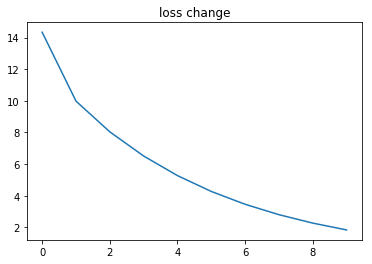

In [229]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

# task3 PyTorch实现Logistic regression

参考[Pytorch实现逻辑回归](https://blog.csdn.net/herosunly/article/details/89130368)

## 公式推导

$\hat{y}_{i}=\frac{1}{1+e^{-\left(w \cdot x_{i}+b\right)}}$

极大似然思想

$maxL=\prod_{i=1}^{N} \hat{y}_{i}^{y_{i}} \cdot\left(1-\hat{y}_{i}\right)^{\left(1-{y_{i}}\right)}$

$max\ln L=\sum_{i=1}^{N} y_{i} \ln \hat{y}_{i}+\left(1-y_{i}\right) \ln \left(1-\hat{y}_{i}\right)$

$\max \ln L=\min(-\ln L)$

## 一、PyTorch基础实现代码

In [40]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [27]:
x_data = Variable(torch.Tensor([[0.1,0.3],[0.2,0.6],[0.2,0.8],[0.4,0.7],[0.4,0.2],[0.6,0.4],[0.6,0.6],[0.8,0.8],[1,0.4]]))
y_data = Variable(torch.Tensor([[1],[1],[1],[1],[0],[0],[0],[0],[0]]))

In [50]:
x_data.numpy()[:4,0]

array([0.1, 0.2, 0.2, 0.4], dtype=float32)

In [46]:
x_data

tensor([[0.1000, 0.3000],
        [0.2000, 0.6000],
        [0.2000, 0.8000],
        [0.4000, 0.7000],
        [0.4000, 0.2000],
        [0.6000, 0.4000],
        [0.6000, 0.6000],
        [0.8000, 0.8000],
        [1.0000, 0.4000]])

In [29]:
y_data

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [95]:
dim_in = x_data.shape[1] # IN
dim_out = 1  # OUT

w = torch.randn(dim_in, dim_out, requires_grad=True)     # IN * OUT
b = torch.randn(dim_out, requires_grad=True)                  #bias，偏置项

eta = 0.1
epochs = 10
loss_ = []
for epoch in range(epochs):
    #Forward pass
    h = x_data @ w + b                                                    
    y_pred = 1 / (1 + torch.exp(-h))                                    #sigmod激活函数

    #Loss
    loss = -torch.sum(y_data * torch.log(y_pred) + (1 - y_data) * torch.log(1 - y_pred)) 
    #print('epoch is {}, loss is {}'.format(epoch, loss.item()))
    loss_.append(float(loss.data))
    loss.backward()

    w.data = w.data - eta * w.grad.data
    b.data = b.data - eta * b.grad.data
    w.grad.data.zero_()
    b.grad.data.zero_()

In [96]:
w

tensor([[-1.0555],
        [-0.5740]], requires_grad=True)

In [97]:
b

tensor([0.5133], requires_grad=True)

In [98]:
line_x = np.arange(10)/10
line_y = (-w.data.numpy()[0]*line_x-b.data.numpy()[0])/w.data.numpy()[1]

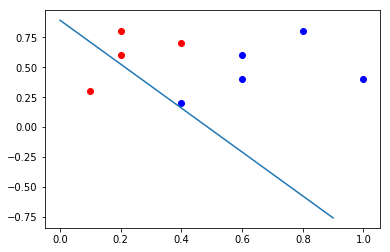

In [99]:
plt.figure()
plt.scatter(x_data.numpy()[:4,0],x_data.numpy()[:4,1] , marker='o', color='red')
plt.scatter(x_data.numpy()[4:,0],x_data.numpy()[4:,1] , marker='o', color='blue')
plt.plot(line_x,line_y)
plt.show()